In [272]:
import numpy as np
import pandas as pd
import os, shutil, re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, classification_report, accuracy_score 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import LeavePGroupsOut
from scipy.sparse import coo_matrix
from sklearn.svm import SVC
from sklearn.utils import resample
import joblib
from numpy.random import seed

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.random import set_seed
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import np_utils
import check_dirs

In [2]:
def bivar_transform(value, standard):
    """
    parms:
    value: input label
    standard: the label that is preserved, all other labels are set to be 'other'
    standrd is in {'1', '2', 'b', 'c', 'm', 'p', 't', 'x'}
    """
    if value != standard:
        return 'other'
    else:
        return standard
    
def bivar(data, standard):
    data_cp = data.copy()
    for i in range(data.shape[0]):
        temp = bivar_transform(data.iloc[:,-1][i], standard)
        data_cp.iloc[:,-1][i] = temp
    return data_cp

In [19]:
main_path = os.getcwd()
dir_list = os.listdir(os.path.join(main_path,'p1'))
def lopo(p, standard: str = None):
    """
    LOPO
    parms:
    p: leave one participant out p in [1,2,3,4,5,6,7]
    return: two dictionaries (train, test)
    """
    train_data = {}
    test_data = {}
    main_list = ['p'+str(i) for i in range(1,8)]
    main_list.remove('p'+str(p))
    for i in main_list:
        for j in dir_list:
            d = pd.read_csv(os.path.join(main_path,i,j),low_memory=False)
            if standard is not None:
                d = bivar(d, standard)
            d = np.array(d)
            if train_data.get(j) is None:
                train_data[j] = d
            else:
                train_data[j] = np.r_[train_data[j],d]
    
    for i in dir_list:
        d = pd.read_csv(os.path.join(main_path,'p'+str(p),i),low_memory=False)
        if standard is not None:
            d = bivar(d, standard)
        d = np.array(d)
        test_data[i] = d
    return train_data, test_data

In [20]:
train_data, test_data = lopo(7)

In [21]:
def get_merged_data(train_data, test_data):
    merged_train, merged_test = [], []
    for i in train_data:
        if len(merged_train) == 0:
            merged_train = train_data[i]
            merged_test = test_data[i]
        else:
            merged_train = np.r_[merged_train,train_data[i]]
            merged_test = np.r_[merged_test,test_data[i]]
    return merged_train, merged_test

In [22]:
merged_train, merged_test = get_merged_data(train_data, test_data)

In [24]:
(merged_train.shape,merged_test.shape)

((35259, 1001), (6672, 1001))

In [10]:
clf = OneVsRestClassifier(RandomForestClassifier(max_depth=10, random_state=0)).fit(merged_train[:,:-1], merged_train[:,-1])

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           b       0.00      0.00      0.00       0.0
           c       0.00      0.00      0.00       0.0
       other       0.00      0.00      0.00    6672.0
           p       0.00      0.00      0.00       0.0
           t       0.00      0.00      0.00       0.0

    accuracy                           0.00    6672.0
   macro avg       0.00      0.00      0.00    6672.0
weighted avg       0.00      0.00      0.00    6672.0



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
merged_test_pred = clf.predict(merged_test[:,:-1])
print(classification_report(merged_test[:,-1],merged_test_pred))

              precision    recall  f1-score   support

           1       0.84      0.82      0.83      1615
           2       0.32      0.19      0.24       370
           b       0.67      0.89      0.77      2095
           c       0.00      0.00      0.00         0
           m       0.00      0.00      0.00        91
           p       0.09      0.01      0.01       132
           t       0.81      0.71      0.75      2350
           x       0.00      0.00      0.00        19

    accuracy                           0.74      6672
   macro avg       0.34      0.33      0.33      6672
weighted avg       0.72      0.74      0.72      6672



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
clf = OneVsOneClassifier(RandomForestClassifier(max_depth=12, random_state=0)).fit(merged_train[:,:-1], merged_train[:,-1])

In [58]:
merged_test_pred = clf.predict(merged_test[:,:-1])
print(classification_report(merged_test[:,-1],merged_test_pred))

              precision    recall  f1-score   support

           1       0.86      0.81      0.84      1615
           2       0.41      0.35      0.38       370
           b       0.68      0.89      0.77      2095
           c       0.00      0.00      0.00         0
           m       0.00      0.00      0.00        91
           p       0.29      0.02      0.03       132
           t       0.82      0.71      0.76      2350
           x       0.00      0.00      0.00        19

    accuracy                           0.75      6672
   macro avg       0.38      0.35      0.35      6672
weighted avg       0.74      0.75      0.73      6672



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
sound_dir = './'
sub_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
feat_size=1000
sound_list = []
# obtain the path to all csv files
for sub in sub_list:
    sound_dir = './%s/' % sub
    sound_list_sub = [os.path.join(sound_dir, item) \
                      for item in os.listdir(sound_dir) if item.endswith('.csv')]
    sound_list.extend(sound_list_sub)
    
sound_data, groups = [], []   # groups is the subject index for each instance
for item in sound_list:
    sub_idx = int(item.split('/')[-2][1:])   # item: .../P1/embedding_1s/outdoor_refine.csv, extract x from Px
    audio_seg = pd.read_csv(item, delimiter=',', header=None, dtype=str).values
    groups.extend([sub_idx] * len(audio_seg))
    sound_data.append(audio_seg)
sound_data = np.concatenate(sound_data, axis = 0)
features, labels = sound_data[:, :feat_size].astype(float), sound_data[:, -1]
groups = np.asarray(groups)

In [123]:
"""
only keep 1,2,x
"""
idx_voice = np.where(labels == '1')
idx_2voice = np.where(labels == '2')
idx_undef = np.where(labels == 'x')
labels_voice = labels[idx_voice]
labels_2voice = labels[idx_2voice]
labels_undef = labels[idx_undef]
labels = np.concatenate((labels_voice, labels_2voice, labels_undef))
features_voice = features[idx_voice]
features_2voice = features[idx_2voice]
features_undef = features[idx_undef]
features = np.concatenate((features_voice, features_2voice, features_undef))
groups_voice = groups[idx_voice]
groups_2voice = groups[idx_2voice]
groups_undef = groups[idx_undef]
groups = np.concatenate((groups_voice, groups_2voice, groups_undef))

idx_voice = np.where(labels == '1')   
labels[idx_voice] = 0
idx_2voice = np.where(labels == '2')   
labels[idx_2voice] = 1
idx_undef = np.where(labels == 'x')   
labels[idx_undef] = 2

labels = labels.astype(int) 

In [136]:
t= 10
features_new = np.empty((0,1000))
groups_new = np.empty((0,1))
labels_new = np.empty((0,1))
for i in range(0, len(labels)-t, t):
    # only mean the instances within the same groups(subjects) and ignore ones of the transition
    if groups[i] == groups[i+t]:        
        temp_feat = features[i:i+t]
        # mean for every t seconds
        mean_feat = np.mean(temp_feat, axis=0)
        #mean_feat = temp_feat
        mean_feat = np.reshape(mean_feat, (1,1000))
    else:
        pass
    features_new = np.vstack((features_new, mean_feat))
    labels_new = np.vstack((labels_new, labels[i]))
    groups_new = np.vstack((groups_new, groups[i]))
labels_new = labels_new.astype(int)
groups_new = groups_new.reshape((groups_new.shape[0], ))
groups_new = groups_new.astype(int)

In [137]:
# def new_unit_data(features, labels, groups, t):
#     t= 10
#     features_new = np.empty((0,1000))
#     groups_new = np.empty((0,1))
#     labels_new = np.empty((0,1))
#     for i in range(0, len(labels)-t, t):
#         # only mean the instances within the same groups(subjects) and ignore ones of the transition
#         if features[i] == features[i+t]:        
#             temp_feat = features[i:i+t]
#             # mean for every t seconds
#             mean_feat = np.mean(temp_feat, axis=0)
#             #mean_feat = temp_feat
#             mean_feat = np.reshape(mean_feat, (1,1000))
#         else:
#             pass
#         features_new = np.vstack((features_new, mean_feat))
#         labels_new = np.vstack((labels_new, labels[i]))
#         groups_new = np.vstack((groups_new, groups[i]))
#     labels_new = labels_new.astype(int)
#     groups_new = groups_new.reshape((groups_new.shape[0], ))
#     groups_new = groups_new.astype(int)
#     return features_new, labels_new, groups_new

In [217]:
class model_nn():
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def model(self):    
        model = Sequential()
        model.add(L.Conv2D(64, strides=2, kernel_size=4, activation='relu', padding='same', input_shape=self.input_shape))
        model.add(L.Conv2D(128, strides=2, kernel_size=4, activation='relu', padding='same'))
        model.add(L.Conv2D(256, strides=2, kernel_size=4, activation='relu', padding='same'))
        model.add(L.Conv2D(512, strides=2, kernel_size=4, activation='relu', padding='same'))
        model.add(L.Flatten())
        model.add(L.Dense(1024, activation='relu'))
        model.add(L.Dropout(0.2))
        model.add(L.Dense(128, activation='relu'))
        model.add(L.Dropout(0.2))
        model.add(L.Dense(3, activation='sigmoid'))
    
        # Compile the model
        opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss=categorical_crossentropy,
                      optimizer=opt,
                      metrics=['categorical_accuracy'])
        return model

In [148]:
def last_4chars(x):    
    return(int(x.split('/')[-1].split('-')[0][4:]))

In [158]:
features_new.shape, labels_new.shape, groups_new.shape

((1476, 1000), (1476, 1), (1476,))

In [276]:
Counter(labels_new.reshape((1,-1))[0])

Counter({0: 887, 1: 536, 2: 53})

In [312]:
"""
resample to balance data
"""
concat_data = np.c_[features_new, labels_new, groups_new]
concat_1 = concat_data[concat_data[:,-2]==0]
concat_1 = resample(concat_1, n_samples=500, random_state=0)
concat_2 = concat_data[concat_data[:,-2]==1]
concat_2 = resample(concat_2, n_samples=500, random_state=0)
concat_x = concat_data[concat_data[:,-2]==2]
concat_x = resample(concat_x, n_samples=500, random_state=0)
concat_data = np.concatenate((concat_1,concat_2,concat_x))
features_new = concat_data[:,:-2]
labels_new = concat_data[:,-2]
groups_new = concat_data[:,-1]

In [198]:
def format_input(data):
    new_data = []
    for i in data:
        temp_data = i.reshape((25,40,1))
        new_data.append(temp_data)
    return np.asarray(new_data,dtype=np.float) 

In [315]:
seed(0)
# keras seed
set_seed(0)
#features_new = np.expand_dims(features_new, axis=-1).astype(float)
#%%
          
NN = True
if NN:
    predict = False
    save_model_path = './models_resample/'
    check_dirs.check_dir(save_model_path)
    batch_size = 16
    lppo = LeavePGroupsOut(n_groups=1)
    #lppo = GroupKFold(n_splits=2)
    #kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
    fold_no = 1
    f1_per_fold, acc_per_fold, pre_per_fold, rec_per_fold = [], [], [], []
    # training
    if not predict:
        #for train, test in kfold.split(features, labels):
        for train, test in lppo.split(features_new, labels_new, groups_new):
            feat_train, labels_train = features_new[train], labels_new[train]
            feat_test, labels_test = features_new[test], labels_new[test]
            feat_train = format_input(feat_train)
            feat_test = format_input(feat_test)
            labels_train = np_utils.to_categorical(labels_train)
            labels_test = np_utils.to_categorical(labels_test)
            model_fold = model_nn(input_shape=(25, 40, 1)).model()
            # Fit data to model, only models with the best val acc (unbalanced) are saved
            model_fold.fit(feat_train, labels_train,
                           batch_size=batch_size,
                           epochs=5,
                           validation_data=(feat_test, labels_test),
                           verbose=2,
                           callbacks=[K.callbacks.ModelCheckpoint(save_model_path+"fold%01d-epoch_{epoch:02d}-acc_{val_categorical_accuracy:.4f}.h5" %fold_no, 
                                                                  monitor='val_categorical_accuracy', 
                                                                  verbose=0, 
                                                                  save_best_only=True, 
                                                                  save_weights_only=True, 
                                                                  mode='auto', 
                                                                  save_freq='epoch')])
            del model_fold
            fold_no = fold_no + 1
    # validation                     
    if predict:
        models = sorted([os.path.join(save_model_path, item) \
                         for item in os.listdir(save_model_path) if item.endswith('.h5')], key=last_4chars)
        #for train, test in kfold.split(features, labels):
        for train, test in lppo.split(features_new, labels_new, groups=groups_new):
#             feat_train, labels_train = features_new[train], labels_new[train]
            feat_test, labels_test = features_new[test], labels_new[test]
            feat_test = format_input(feat_test)
            labels_test = np_utils.to_categorical(labels_test)
            model_pred = model_nn(input_shape=(25, 40, 1)).model()
            model_pred.load_weights(models[fold_no - 1])
            # prediction
            pred_prob = model_pred.predict(feat_test)
            # set threshold for binary classification
            idx_p = np.where(pred_prob > 0.5)
            idx_n = np.where(pred_prob <= 0.5)
            pred_prob[idx_p] = 1
            pred_prob[idx_n] = 0

            acc_per_fold.append(balanced_accuracy_score(labels_test, pred_prob) * 100)
            f1_per_fold.append(f1_score(labels_test, pred_prob, average = 'macro') * 100)  
            # initialize
            del model_pred
            fold_no = fold_no + 1
        f1 = np.mean(f1_per_fold)
        acc = np.mean(acc_per_fold)
        print('acc: ', acc, '\n f1: ', f1)

Epoch 1/5
73/73 - 6s - loss: 1.0850 - categorical_accuracy: 0.4220 - val_loss: 1.0698 - val_categorical_accuracy: 0.4671
Epoch 2/5
73/73 - 6s - loss: 0.8898 - categorical_accuracy: 0.5806 - val_loss: 0.7807 - val_categorical_accuracy: 0.3413
Epoch 3/5
73/73 - 6s - loss: 0.6883 - categorical_accuracy: 0.6492 - val_loss: 0.8767 - val_categorical_accuracy: 0.4731
Epoch 4/5
73/73 - 6s - loss: 0.5983 - categorical_accuracy: 0.7033 - val_loss: 1.1653 - val_categorical_accuracy: 0.4042
Epoch 5/5
73/73 - 5s - loss: 0.5045 - categorical_accuracy: 0.7744 - val_loss: 1.2373 - val_categorical_accuracy: 0.5090
Epoch 1/5
76/76 - 6s - loss: 1.0830 - categorical_accuracy: 0.4312 - val_loss: 1.1260 - val_categorical_accuracy: 0.3902
Epoch 2/5
76/76 - 5s - loss: 0.9198 - categorical_accuracy: 0.5829 - val_loss: 0.8190 - val_categorical_accuracy: 0.4007
Epoch 3/5
76/76 - 5s - loss: 0.7072 - categorical_accuracy: 0.6348 - val_loss: 0.8657 - val_categorical_accuracy: 0.4042
Epoch 4/5
76/76 - 5s - loss: 0.6

In [316]:
"""
for evaluation
!!!!!!!!
!!!!!!!
!!!!!
!!!!
!!
!

"""
seed(0)
# keras seed
set_seed(0)
#features_new = np.expand_dims(features_new, axis=-1).astype(float)
#%%
          
NN = True
if NN:
    predict = True
    save_model_path = './models_resample/'
    batch_size = 16
    lppo = LeavePGroupsOut(n_groups=1)
    #lppo = GroupKFold(n_splits=2)
    #kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
    fold_no = 1
    f1_per_fold, acc_per_fold, pre_per_fold, rec_per_fold, balanced_acc_per_fold = [], [], [], [], []
    # training
    if not predict:
        #for train, test in kfold.split(features, labels):
        for train, test in lppo.split(features_new, labels_new, groups_new):
            feat_train, labels_train = features_new[train], labels_new[train]
            feat_test, labels_test = features_new[test], labels_new[test]
            feat_train = format_input(feat_train)
            feat_test = format_input(feat_test)
            labels_train = np_utils.to_categorical(labels_train)
            labels_test = np_utils.to_categorical(labels_test)
            model_fold = model_nn(input_shape=(25, 40, 1)).model()
            # Fit data to model, only models with the best val acc (unbalanced) are saved
            model_fold.fit(feat_train, labels_train,
                           batch_size=batch_size,
                           epochs=5,
                           validation_data=(feat_test, labels_test),
                           verbose=2,
                           callbacks=[K.callbacks.ModelCheckpoint(save_model_path+"fold%01d-epoch_{epoch:02d}-acc_{val_categorical_accuracy:.4f}.h5" %fold_no, 
                                                                  monitor='val_categorical_accuracy', 
                                                                  verbose=0, 
                                                                  save_best_only=True, 
                                                                  save_weights_only=True, 
                                                                  mode='auto', 
                                                                  save_freq='epoch')])
            del model_fold
            fold_no = fold_no + 1
    # validation                     
    if predict:
        models = sorted([os.path.join(save_model_path, item) \
                         for item in os.listdir(save_model_path) if item.endswith('.h5')], key=last_4chars)
        #for train, test in kfold.split(features, labels):
        for train, test in lppo.split(features_new, labels_new, groups=groups_new):
#             feat_train, labels_train = features_new[train], labels_new[train]
            feat_test, labels_test = features_new[test], labels_new[test]
            feat_test = format_input(feat_test)
            labels_test = np_utils.to_categorical(labels_test)
            model_pred = model_nn(input_shape=(25, 40, 1)).model()
            model_pred.load_weights(models[fold_no - 1])
            # prediction
            pred_prob = model_pred.predict(feat_test)
#             pred_prob = pred_prob.argmax(axis=1)
            result = []
            for i in pred_prob:
                temp = i.argmax(axis=0)
                if temp == 0:
                    result.append([1,0,0])
                elif temp == 1:
                    result.append([0,1,0])
                else:
                    result.append([0,0,1])
            result = np.asarray(result, dtype=np.int)
#             print(np.argsort(pred_prob,axis=1))
#             break
#             acc_per_fold.append(balanced_accuracy_score(labels_test, pred_prob) * 100)
#             f1_per_fold.append(f1_score(labels_test, pred_prob, average = 'macro') * 100) 
            f1_per_fold.append(f1_score(labels_test, result,average='weighted'))
            acc_per_fold.append(accuracy_score(labels_test, result))
            balanced_acc_per_fold.append(balanced_accuracy_score([np.argmax(one_hot)for one_hot in labels_test],[np.argmax(one_hot)for one_hot in result]))
            print(classification_report(labels_test,result))
            # initialize
            del model_pred
            fold_no = fold_no + 1
        f1 = np.mean(f1_per_fold)
        acc = np.mean(acc_per_fold)
        balanced_acc = np.mean(balanced_acc_per_fold)
        print('acc: ', acc, '\n f1: ', f1, '\n balanced_acc: ', balanced_acc)

              precision    recall  f1-score   support

           0       0.55      0.95      0.70        91
           1       0.14      0.06      0.09       124
           2       0.51      0.52      0.52       119

   micro avg       0.47      0.47      0.47       334
   macro avg       0.40      0.51      0.43       334
weighted avg       0.38      0.47      0.41       334
 samples avg       0.47      0.47      0.47       334



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.70      0.98      0.82        51
           1       0.34      0.94      0.50        79
           2       0.00      0.00      0.00       157

   micro avg       0.43      0.43      0.43       287
   macro avg       0.35      0.64      0.44       287
weighted avg       0.22      0.43      0.28       287
 samples avg       0.43      0.43      0.43       287

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       0.87      0.63      0.73        95
           2       0.67      0.89      0.76        81

   micro avg       0.81      0.81      0.81       238
   macro avg       0.85      0.83      0.83       238
weighted avg       0.83      0.81      0.81       238
 samples avg       0.81      0.81      0.81       238

              precision    recall  f1-score   support

           0       0.69      0.96      0.80        49
           1       0.

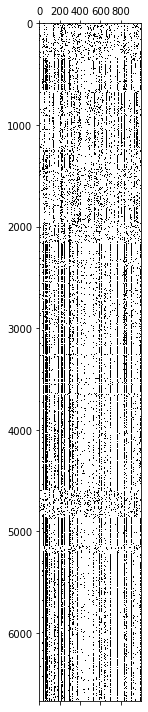

In [31]:
fig, axs = plt.subplots(1,figsize=(10,10))
plt.spy(merged_test[:,:-1])
plt.tight_layout()
plt.show()

In [35]:
print(Counter(merged_train[:,-1]))
print(Counter(merged_test[:,-1]))

Counter({'b': 11008, 't': 8641, '1': 7211, '2': 4988, 'p': 1141, 'm': 1111, 'c': 642, 'x': 517})
Counter({'t': 2350, 'b': 2095, '1': 1615, '2': 370, 'p': 132, 'm': 91, 'x': 19})


In [44]:
def boostrap_merged_data(merged_train):
    train_class = Counter(merged_train[:,-1])
    resample_train = []
    for i in train_class:
        temp_data = merged_train[merged_train[:,-1]==i]
        temp_data = resample(temp_data, n_samples=6000, random_state=0)
        if len(resample_train) == 0:
            resample_train = temp_data
        else:
            resample_train = np.r_[resample_train,temp_data]
    return resample_train

In [45]:
resample_train = boostrap_merged_data(merged_train)

In [47]:
# resample_train_X = coo_matrix(resample_train[:,:-1])

In [49]:
clf = OneVsRestClassifier(RandomForestClassifier(max_depth=10, random_state=0)).fit(resample_train[:,:-1], resample_train[:,-1])

In [50]:
resample_test_pred = clf.predict(resample_test[:,:-1])
print(classification_report(resample_test[:,-1],resample_test_pred))

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.44      0.69      0.54      6000
           2       0.36      0.18      0.24      6000
           b       0.47      0.86      0.61      6000
           c       0.00      0.00      0.00         0
           m       0.40      0.16      0.23      6000
           p       0.38      0.18      0.25      6000
           t       0.37      0.73      0.49      6000
           x       0.36      0.05      0.09      6000

    accuracy                           0.41     42000
   macro avg       0.35      0.35      0.30     42000
weighted avg       0.40      0.41      0.35     42000



In [4]:
def lopo_count(data, standard):
    """
    parms:
    data: could be one of train_data and test_data
    standard: same as bivar_transform
    return: tuple contains the number of two labels (standard and 'other')
    """
    standard_count, other_count = 0, 0
    for i in data:
        count = Counter(data[i][:,-1])
        if len(count) == 2:
            other_count += count['other']
            standard_count += count[standard]
        else:
            other_count += count['other']
    return standard_count, other_count

In [11]:
"""
这里用 'm' 和 p7 为例
"""
train_data, test_data = lopo(p=6, standard='m')
m_count_train, other_count_train = lopo_count(train_data, standard='m')
m_count_test, other_count_test = lopo_count(test_data, standard='m')
print('In train_data: ' + str(m_count_train) + " 'm' " + str(other_count_train) + " 'other' ")
print('In test_data: ' + str(m_count_test) + " 'm' " + str(other_count_test) + " 'other' ")

<ipython-input-2-be0bada80baa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cp.iloc[:,-1][i] = temp


In train_data: 1050 'm' 34236 'other' 
In test_data: 152 'm' 6493 'other' 


In [6]:
"""
对每个场景单独训练模型一共6个,这里我用了rf和adaboost
"""
def model_dict(data, model: str):
    """
    parms:
    model: model in ['rf','adaboost']
    """
    model_dict = dict()
    if model == 'rf':
        for i in data:
            rfc = RandomForestClassifier(max_depth=30, random_state=0) #max_depth ~ sqrt(n_features=1000)
            rfc.fit(data[i][:,:-1],data[i][:,-1])
            model_dict[i] = rfc
    elif model == 'adaboost':
        for i in data:
            ada = AdaBoostClassifier(n_estimators=50, random_state=0)
            ada.fit(data[i][:,:-1],data[i][:,-1])
            model_dict[i] = ada
    return model_dict

In [12]:
model_dict_rf = model_dict(train_data, model='rf')
# model_dict_ada = model_dict(train_data, model='adaboost')

In [13]:
"""
rf/adaboost as the baseline and calculate the score for test_data
"""
for i in test_data:
    print('score for ' + i)
    print('rf',model_dict_rf[i].score(test_data[i][:,:-1],test_data[i][:,-1]))
#     print('adaboost',model_dict_ada[i].score(test_data[i][:,:-1],test_data[i][:,-1]))
    print("\n")

score for outdoor.csv
rf 0.9699812382739212


score for reading.csv
rf 1.0


score for call.csv
rf 1.0


score for dinner.csv
rf 0.9930887825624668


score for game.csv
rf 0.9251412429378532


score for TV.csv
rf 0.9867549668874173




In [14]:
for i in test_data:
    print('report for ' + i)
    print('rf')
    print(classification_report(test_data[i][:,-1],model_dict_rf[i].predict(test_data[i][:,:-1])))
#     print('rf',model_dict_rf[i].score(test_data[i][:,:-1],test_data[i][:,-1]))
#     print('adaboost',model_dict_ada[i].score(test_data[i][:,:-1],test_data[i][:,-1]))
#     print('adaboost')
#     print(classification_report(test_data[i][:,-1],model_dict_ada[i].predict(test_data[i][:,:-1])))
    print("\n")

report for outdoor.csv
rf
              precision    recall  f1-score   support

           m       0.00      0.00      0.00        16
       other       0.97      1.00      0.98       517

    accuracy                           0.97       533
   macro avg       0.48      0.50      0.49       533
weighted avg       0.94      0.97      0.96       533



report for reading.csv
rf
              precision    recall  f1-score   support

       other       1.00      1.00      1.00       226

    accuracy                           1.00       226
   macro avg       1.00      1.00      1.00       226
weighted avg       1.00      1.00      1.00       226



report for call.csv
rf
              precision    recall  f1-score   support

       other       1.00      1.00      1.00       406

    accuracy                           1.00       406
   macro avg       1.00      1.00      1.00       406
weighted avg       1.00      1.00      1.00       406



report for dinner.csv
rf


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           m       0.00      0.00      0.00        26
       other       0.99      1.00      1.00      3736

    accuracy                           0.99      3762
   macro avg       0.50      0.50      0.50      3762
weighted avg       0.99      0.99      0.99      3762



report for game.csv
rf
              precision    recall  f1-score   support

           m       0.00      0.00      0.00       106
       other       0.93      1.00      0.96      1310

    accuracy                           0.93      1416
   macro avg       0.46      0.50      0.48      1416
weighted avg       0.86      0.93      0.89      1416



report for TV.csv
rf
              precision    recall  f1-score   support

           m       0.00      0.00      0.00         4
       other       0.99      1.00      0.99       298

    accuracy                           0.99       302
   macro avg       0.49      0.50      0.50       302
weighted avg       0.97   

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
"""
强烈建议试试其他人或者其他标签
"""

'\n强烈建议试试其他人或者其他标签\n'

In [15]:
"""
这里以下到下一个注释是之前写的有点乱。。。
表示的是不做二分类，强行用rf/adaboost对六个场景所有标签直接分类. 效果很差
"""
main_path = os.getcwd()
dir_list = os.listdir(os.path.join(main_path,'p1'))
original_data = {}
main_list = ['p'+str(i) for i in range(1,7)]
for i in main_list:
    for j in dir_list:
        d = pd.read_csv(os.path.join(main_path,i,j),low_memory=False)
        d = np.array(d)
        if original_data.get(j) is None:
            original_data[j] = d
        else:
            original_data[j] = np.r_[original_data[j],d]

In [16]:
original_test_data = dict()
for i in dir_list:
    d = pd.read_csv(os.path.join(main_path,'p7',i),low_memory=False)
    d = np.array(d)
    original_test_data[i] = d

In [155]:
original_model_dict = dict()
for i in data:
    rfc = RandomForestClassifier(max_depth=30, random_state=0)
    rfc.fit(original_data[i][:,:-1],original_data[i][:,-1])
    original_model_dict[i] = rfc

In [172]:
for i in original_test_data:
    temp_data = original_test_data[i]
    print("\n",i)
    y_pred = original_model_dict[i].predict(temp_data[:,:-1]) 
    print(classification_report(original_test_data[i][:,-1],y_pred))


 outdoor.csv
              precision    recall  f1-score   support

           1       0.71      0.74      0.72       273
           2       0.28      0.31      0.29       100
           b       0.86      0.87      0.86       284
           m       0.00      0.00      0.00        26
           x       0.00      0.00      0.00         1

    accuracy                           0.70       684
   macro avg       0.37      0.38      0.38       684
weighted avg       0.68      0.70      0.69       684


 reading.csv
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       213
           b       0.86      0.67      0.75        18

    accuracy                           0.97       231
   macro avg       0.91      0.83      0.87       231
weighted avg       0.96      0.97      0.96       231


 call.csv
              precision    recall  f1-score   support

           1       0.91      0.98      0.94       336
           b       0.00      0.00   

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           1       0.93      0.69      0.79       557
           2       0.39      0.38      0.39       198
           b       0.70      0.94      0.81      1462
           m       0.00      0.00      0.00        18
           p       0.00      0.00      0.00         7
           t       0.73      0.48      0.58       922
           x       0.00      0.00      0.00        13

    accuracy                           0.72      3177
   macro avg       0.39      0.36      0.37      3177
weighted avg       0.72      0.72      0.70      3177


 game.csv
              precision    recall  f1-score   support

           1       0.72      0.82      0.77       201
           2       0.59      0.57      0.58        72
           b       0.90      0.91      0.90       278
           m       0.00      0.00      0.00        24
           t       0.00      0.00      0.00         0
           x       0.00      0.00      0.00         5

    accuracy

In [34]:
"""
每个场景的train/test标签对比情况
"""
for i in original_test_data:
    print(i)
    print(Counter(original_data[i][:,-1]))
    print(Counter(original_test_data[i][:,-1]))
    print("\n")

outdoor.csv
Counter({'b': 791, '1': 768, '2': 746, 'm': 179, 'x': 125, 'c': 82})
Counter({'b': 284, '1': 273, '2': 100, 'm': 26, 'x': 1})


reading.csv
Counter({'1': 1084, 'b': 138, 'x': 5, '2': 1, 'm': 1})
Counter({'1': 213, 'b': 18})


call.csv
Counter({'p': 1112, '1': 973, 'b': 142, 'm': 129, 'c': 13, '2': 5})
Counter({'1': 336, 'p': 125, 'b': 23, 'm': 23})


dinner.csv
Counter({'b': 8191, 't': 5634, '2': 3056, '1': 2236, 'm': 430, 'c': 404, 'x': 323, 'p': 29})
Counter({'b': 1462, 't': 922, '1': 557, '2': 198, 'm': 18, 'x': 13, 'p': 7})


game.csv
Counter({'1': 1905, 'b': 1544, '2': 896, 'm': 343, 't': 281, 'c': 62, 'x': 39})
Counter({'b': 278, '1': 201, '2': 72, 'm': 24, 'x': 5})


TV.csv
Counter({'t': 2726, '2': 284, '1': 245, 'b': 202, 'c': 81, 'm': 29, 'x': 25})
Counter({'t': 1428, '1': 35, 'b': 30})




In [178]:
original_adaboost_dict = dict()
for i in data:
    rfc = AdaBoostClassifier(n_estimators=100, random_state=0)
    rfc.fit(original_data[i][:,:-1],original_data[i][:,-1])
    original_adaboost_dict[i] = rfc

In [179]:
for i in original_test_data:
    temp_data = original_test_data[i]
    print("\n",i)
    y_pred = original_adaboost_dict[i].predict(temp_data[:,:-1]) 
    print(classification_report(original_test_data[i][:,-1],y_pred))


 outdoor.csv


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.68      0.61      0.64       273
           2       0.07      0.06      0.07       100
           b       0.76      0.86      0.81       284
           c       0.00      0.00      0.00         0
           m       0.13      0.12      0.12        26
           x       0.00      0.00      0.00         1

    accuracy                           0.61       684
   macro avg       0.27      0.27      0.27       684
weighted avg       0.60      0.61      0.61       684


 reading.csv
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       213
           b       0.87      0.72      0.79        18

    accuracy                           0.97       231
   macro avg       0.92      0.86      0.89       231
weighted avg       0.97      0.97      0.97       231


 call.csv


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.89      0.98      0.93       336
           b       0.00      0.00      0.00        23
           m       0.00      0.00      0.00        23
           p       0.80      0.87      0.83       125

    accuracy                           0.86       507
   macro avg       0.42      0.46      0.44       507
weighted avg       0.78      0.86      0.82       507


 dinner.csv


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.81      0.63      0.71       557
           2       0.20      0.16      0.18       198
           b       0.69      0.86      0.77      1462
           c       0.00      0.00      0.00         0
           m       0.05      0.11      0.07        18
           p       0.00      0.00      0.00         7
           t       0.64      0.50      0.56       922
           x       0.00      0.00      0.00        13

    accuracy                           0.66      3177
   macro avg       0.30      0.28      0.28      3177
weighted avg       0.66      0.66      0.65      3177


 game.csv


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.55      0.32      0.41       201
           2       0.58      0.31      0.40        72
           b       0.85      0.78      0.81       278
           c       0.00      0.00      0.00         0
           m       0.09      0.46      0.15        24
           t       0.00      0.00      0.00         0
           x       0.00      0.00      0.00         5

    accuracy                           0.54       580
   macro avg       0.29      0.27      0.25       580
weighted avg       0.67      0.54      0.59       580


 TV.csv
              precision    recall  f1-score   support

           1       0.81      0.37      0.51        35
           2       0.00      0.00      0.00         0
           b       0.01      0.03      0.02        30
           c       0.00      0.00      0.00         0
           m       0.00      0.00      0.00         0
           t       0.97      0.94      0.96      1428
           x   

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
"""
这边开始是 cleanlab 洗标签过程
[这部分我昨天做的时候是对6个场景分别训一个模型然后分别洗掉错误标签] 但过程里其实是有点小问题的，他这个算法原理需要做交叉验证然后从之前那个train/test label分布里面我们就看到在某些场景中
其实有些label可能只有很少(甚至只有1个)。所以就意味着不能split,就会出现点bug

[所以可能我觉得可以考虑不分场景先把数据洗一遍]
"""
"""
以下代码都是昨天写的，只针对outdoor.csv这一个场景做了测试
先把train和test各自洗一遍（实际情况是test由于某个label只有一个这个算法报错了，于是没洗test直接做的测试，结果也是很一般 '1'这个类基本区分不出来）
"""
from cleanlab.classification import LearningWithNoisyLabels
temp_data = original_data['outdoor.csv']
temp_test = original_test_data['outdoor.csv']

/usr/local/lib/python3.8/site-packages/cleanlab/pruning.py:38: UserWarning: If you want to see estimated completion times
    while running methods in cleanlab.pruning, install tqdm
    via "pip install tqdm".
  warnings.warn(w)


In [18]:
def temp_convert(value):
    if value == '1':
        return 0
    elif value == '2':
        return 1
    elif value == 'b':
        return 2
    elif value == 'c':
        return 3
    elif value == 'm':
        return 4
    elif value == 'x':
        return 5

def temp_transform(data):
    data_cp = data.copy()
    for i in range(data.shape[0]):
        temp = temp_convert(data[:,-1][i])
        data_cp[:,-1][i] = temp
    return data_cp

In [19]:
temp_data = temp_transform(temp_data)
temp_test = temp_transform(temp_test)

In [20]:
temp_data_X = np.array(temp_data[:,:-1],dtype=np.float)
temp_data_Y = np.array(temp_data[:,-1],dtype=np.int64)

In [21]:
temp_test_X = np.array(temp_test[:,:-1],dtype=np.float)
temp_test_Y = np.array(temp_test[:,-1],dtype=np.int64)

In [22]:
# 其实可以封装任意一个你自定义的模型.
lnl = LearningWithNoisyLabels(clf=RandomForestClassifier(max_depth=30,random_state=0))
lnl.fit(X=temp_data_X, s=temp_data_Y)
# 对真实世界进行验证.
predicted_test_labels = lnl.predict(temp_test_X)
# print(classification_report(temp_test_Y,predicted_test_labels))

In [23]:
import cleanlab
psx = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
    temp_data_X, temp_data_Y, clf=RandomForestClassifier(max_depth=30, random_state=0))

In [24]:
from cleanlab.pruning import get_noise_indices
psx = np.asarray(psx)
ordered_label_errors = get_noise_indices(
    s=temp_data_Y,
    psx=psx,
    sorted_index_method='normalized_margin', # Orders label errors
 )

In [25]:
index_list_data = np.array(list(range(len(temp_data_X))))
index_list_test = np.array(list(range(len(temp_test_X))))

In [26]:
cp_index_list_data = []
for i in index_list_data:
    if i in ordered_label_errors:
        cp_index_list_data.append(False)
    else:
        cp_index_list_data.append(True)

In [27]:
Counter(temp_data_Y[cp_index_list_data])

Counter({0: 589, 1: 618, 2: 695, 4: 69, 5: 36, 3: 29})

In [28]:
Counter(temp_data_Y)

Counter({0: 768, 1: 746, 2: 791, 4: 179, 5: 125, 3: 82})

In [260]:
rfc = RandomForestClassifier(max_depth=30, random_state=0)
rfc.fit(temp_data_X[cp_index_list_data,:],temp_data_Y[cp_index_list_data])

RandomForestClassifier(max_depth=30, random_state=0)

In [276]:
"""
再给test洗一次(注意这里就报错了，因为有某个label在这个test里只出现一次) 
"""
psx_test = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
    temp_test_X, temp_test_Y, clf=RandomForestClassifier(max_depth=30, random_state=0))
psx_test = np.asarray(psx_test)
ordered_label_errors_test = get_noise_indices(
    s=temp_test_Y,
    psx=psx_test,
    sorted_index_method='normalized_margin', # Orders label errors
 )
cp_index_list_test = []
for i in index_list_test:
    if i in ordered_label_errors_test:
        cp_index_list_test.append(False)
    else:
        cp_index_list_test.append(True)

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

In [277]:
"""
于是不洗直接测试
可以参考这个链接里面有一个详细的置信学习的代码(一个具体例子)
https://github.com/cgnorthcutt/cleanlab/blob/master/examples/simplifying_confident_learning_tutorial.ipynb
"""
temp_test_Y_pred = rfc.predict(temp_test_X)
print(classification_report(temp_test_Y,temp_test_Y_pred))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       273
           1       0.26      0.35      0.30       100
           2       0.87      0.87      0.87       284
           4       0.00      0.00      0.00        26
           5       0.00      0.00      0.00         1

    accuracy                           0.69       684
   macro avg       0.37      0.38      0.38       684
weighted avg       0.69      0.69      0.69       684



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
